## Rates of sequence evolution in genes on core and fast-core chromosomes

We find that sequences of fast-core chromosomes are more diverged within FOSC and between Fusaria. We also find that genes that are located on the fast-core are involved in infection (enriched for genes that are upregulated *in planta* and enriched for genes involved in metabolism and transport of carbon compounds and sugars). If the higher levels of sequence divergence are a consequence of host-adaptation, we expect that genes that are located in fast-core regions are under positive selection. Yet previous analyses report no enrichment of genes under positive selection for fast-core chromosomes (Sperschneider et al., GBE 2014).  

Are genes that are located on fast-core chromosomes enriched for genes under positive selection when comparing fast-core to core chromosomes rather than to the whole genome? Are genes that are differentially regulated during infection under positive selection?  

We downloaded measure of selection from the Supplementary Online Material by _Sperschneider et al. Genome Biology and Evolution, 2014_ (http://gbe.oxfordjournals.org/lookup/suppl/doi:10.1093/gbe/evv092/-/DC1). 

    

### Chromosomal categories

In [1]:
'''We start with making a few dictionaries mapping scaffolds to chromosomes, to their length, etc. etc'''

###### Chromosomal categories: category -> chromosomes/chromosomal regions  
chr_categories = ['core', 'fast-core', 'lineage-specific', 'pathogenicity']
cat2chrs = {}

cat2chrs['core']             = ['chr01','chr02','chr04','chr05','chr07','chr08','chr09','chr10']
cat2chrs['fast-core']        = ['chr11','chr12','chr13']
cat2chrs['lineage-specific'] = ['chr01_LS', 'chr02_LS', 'chr03A', 'chr06A','chr15']
cat2chrs['pathogenicity']    = ['chr14', 'chr03P', 'chr06P']

chrs = []
for cat in chr_categories:
    chrs += cat2chrs[cat]

###### Chromosome -> scaffold
# Scaffolds per chromosome or chromosomal region, in case of e.g. chr01_LS or chr03P 
chr2scaffolds = {}
chr2scaffolds['chr01']    = [14,1]
chr2scaffolds['chr01_LS'] = [27]
chr2scaffolds['chr02']    = [6,10]
chr2scaffolds['chr02_LS'] = [31]
chr2scaffolds['chr03A']   = [32, 7, 25]
chr2scaffolds['chr03P']   = [47, 18]
chr2scaffolds['chr04']    = [8,4]
chr2scaffolds['chr05']    = [26, 2]
chr2scaffolds['chr06A']   = [9, 33]
chr2scaffolds['chr06P']   = [21, 53, 41, 42]
chr2scaffolds['chr07']    = [5, 13]
chr2scaffolds['chr08']    = [3, 29]
chr2scaffolds['chr09']    = [11, 17]
chr2scaffolds['chr10']    = [20, 15, 45]
chr2scaffolds['chr11']    = [35, 12]
chr2scaffolds['chr12']    = [19, 23]
chr2scaffolds['chr13']    = [16, 39]
chr2scaffolds['chr14']    = [22, 43, 51, 36]
chr2scaffolds['chr15']    = [37, 38, 24, 28]

# Also the other way around
###### Scaffold -> chromosome
scaffold2chromosome = {}
for chrom in chr2scaffolds.keys():
    for s in chr2scaffolds[chrom]:
        scaffold2chromosome['Supercontig_2.'+str(s)] = chrom

###### Scaffold -> length
genomeFilename = 'data/fusarium_oxysporum_f._sp._lycopersici_4287_2_supercontigs.contig2size.tab'
contig2size = {}
for line in open(genomeFilename).readlines():
    contig, size = line.strip().split('\t')
    contig2size[contig] = float(size)
    
# Chromosome -> size
chr2size = {}
for chrom in chr2scaffolds.keys():
    chrsize = 0
    for s in chr2scaffolds[chrom]:
        scaffold2chromosome['Supercontig_2.'+str(s)] = chrom
        chrsize += contig2size['Supercontig_2.'+str(s)] 
    chr2size[chrom] = chrsize

# Add unpositioned scaffolds, make this a separate 'chromosome'
chr2scaffolds ['US'] = []
for scaffold in contig2size:
    if scaffold not in scaffold2chromosome:
        scaffold2chromosome[scaffold] = 'US'
        chr2scaffolds['US'].append(int(scaffold.split('Supercontig_2.')[-1]))
        
###### Genes per scaffold, location per gene
scaffold2genes   = {}
genes2strand2pos = {}
all_genes = set([])
for line in open('data/fusarium_oxysporum_f._sp._lycopersici_4287_2_transcripts.gtf').readlines():
    data = line.split('\t')
    scaffold = data[0]
    gene = data[-1].split('gene_id "')[-1].split('"')[0]
    
    # add to genes per scaffold
    if scaffold not in scaffold2genes:
        scaffold2genes[scaffold] = set([gene])
    else: scaffold2genes[scaffold].add(gene)
    all_genes.add(gene)
    
print(len(all_genes))


20925


### Genes under positive selection

In [2]:
omegagenes    = []
M1M2genes     = []
M7M8genes     = []
allomegagenes = []
allM1M2genes  = []
allM7M8genes  = []

lines = open('data/natural_selection/evv092_Supplementary_Data/Supplementary_Fusarium_DiversifyingSelection.csv')\
.readlines()
for line in lines[1:]:
    data = line.split(',')
    gene = data[0]
    if gene[:4] == 'FOXG':
        allomegagenes.append(gene)
        if float(data[1]) > 1:
            omegagenes.append(gene)
        if data[2] != 'Not calculated':
            allM1M2genes.append(gene)
            if float(data[2])< 0.01:
                M1M2genes.append(gene)
        if data[3] != 'Not calculated':
            allM7M8genes.append(gene)
            if float(data[3])< 0.01:
                M7M8genes.append(gene)
            
print('# genes under positive selection:')
print('dN/dS > 1:', len(omegagenes))
print('P-value M1/M2 < 0.01:', len(M1M2genes))
print('P-value M7/M8 < 0.01:', len(M7M8genes))
all_tests = set(omegagenes).union(set(M1M2genes)).union(set(M7M8genes))
print('Either of the three tests:', len(all_tests))
print('\n\n')



# genes under positive selection:
('dN/dS > 1:', 257)
('P-value M1/M2 < 0.01:', 282)
('P-value M7/M8 < 0.01:', 353)
('Either of the three tests:', 596)





### Per chromosome and per category, how many genes are under positive selection? 
And how many of these are differentially regulated during infection?

In [10]:
# Get sets of differentially regulated genes
import pandas

DEseq_file = open('data/DEseq_output.xlsx', 'rb')
DEseq_df   = pandas.read_excel(DEseq_file).loc[:,['id', 'baseMeanA', 'baseMeanB', 'padj']]
DEseq_file.close()

#print(DEseq_df)

DEG_df  = DEseq_df.loc[DEseq_df['padj']  < 0.01]
DEG_inplanta  = set(DEG_df['id'])
UP_inplanta   = set(DEG_df[(DEG_df['baseMeanA'] < DEG_df['baseMeanB'])]['id'])
DOWN_inplanta = set(DEG_df[(DEG_df['baseMeanA'] > DEG_df['baseMeanB'])]['id'])

# Sanity checks:
if len(UP_inplanta) + len(DOWN_inplanta) != len(DEG_inplanta):
    print("Error! Set sizes don't match:",\
          len(UP_inplanta),'+', len(DOWN_inplanta), 'should be', len(DEG_inplanta))
    

from scipy import stats
# Test whether the overlap is significant:
# The hypergeometric distribution models drawing objects from a bin. 
# M is the total number of objects, n is total number of Type I objects. 
# The random variate represents the number of Type I objects in N drawn without replacement from the total population.

# Dictionary: per test, the number of genes that are under positive selection according to this test, 
# and the number of genes that was tested (i.e. have a homolog in one of the included Fusarium species)
test2genes = {}
test2genes['Omega'] = (omegagenes, allomegagenes)
test2genes['M1M2'] = (M1M2genes, allM1M2genes)
test2genes['M7M8'] = (M7M8genes, allM7M8genes)

tests = ['Omega', 'M1M2', 'M7M8']

for cat in chr_categories:
    cat_genes = set([])
    for chr in cat2chrs[cat]:
        print ('\n\n***\t', chr, '\t***')
        # get number of genes on this chromosome
        chr_genes = set([])
        for scaffold in chr2scaffolds[chr]:
            chr_genes = chr_genes.union(scaffold2genes['Supercontig_2.'+str(scaffold)])
        cat_genes = cat_genes.union(chr_genes)
                 
        Nchr = len(chr_genes) 
        
        all_pos_sel_genes__all_tests = set([])
        all_tested_genes__all_tests = set([])
        for test in tests:
            all_pos_sel_genes = set(test2genes[test][0]).intersection(all_genes)
            all_tested_genes  = set(test2genes[test][1]).intersection(all_genes)

            M = len(all_tested_genes)
            n = len(all_pos_sel_genes)
            N = len(chr_genes.intersection(all_tested_genes))
            x = len(chr_genes.intersection(all_pos_sel_genes))
            
            all_pos_sel_genes__all_tests = all_pos_sel_genes__all_tests.union(all_pos_sel_genes)
            all_tested_genes__all_tests  = all_tested_genes__all_tests.union(all_tested_genes)
            
            print(test+': scipy.stats.hypergeom.sf('+str(M)+','+str(n)+','+str(N)+','+str(x)+')')
            print('P-value:', stats.hypergeom.sf(x, M, n, N))
           
        
        M = len(all_tested_genes__all_tests)
        n = len(all_pos_sel_genes__all_tests)
        N = len(chr_genes.intersection(all_tested_genes__all_tests))
        x = len(chr_genes.intersection(all_pos_sel_genes__all_tests))
        
        print('Either test: scipy.stats.hypergeom.sf('+str(M)+','+str(n)+','+str(N)+','+str(x)+')')
        print('P-value:', stats.hypergeom.sf(x, M, n, N)) 
        
        
    print  ('\n\n\n***\t', cat, '\t***')   
    #Ncat = len(cat_genes)
    for test in tests:
        all_pos_sel_genes = set(test2genes[test][0]).intersection(all_genes)
        all_tested_genes  = set(test2genes[test][1]).intersection(all_genes)

        M = len(all_tested_genes)
        n = len(all_pos_sel_genes)
        N = len(cat_genes.intersection(all_tested_genes))
        x = len(cat_genes.intersection(all_pos_sel_genes))

        print(test+': scipy.stats.hypergeom.sf('+str(M)+','+str(n)+','+str(N)+','+str(x)+')')
        print('P-value:', stats.hypergeom.sf(x, M, n, N))
        all_pos_sel_genes__all_tests = all_pos_sel_genes__all_tests.union(all_pos_sel_genes)
        all_tested_genes__all_tests  = all_tested_genes__all_tests.union(all_tested_genes)
        
       
    M = len(all_tested_genes__all_tests)
    n = len(all_pos_sel_genes__all_tests)
    N = len(cat_genes.intersection(all_tested_genes__all_tests))
    x = len(cat_genes.intersection(all_pos_sel_genes__all_tests))

    print('Either test: scipy.stats.hypergeom.sf('+str(M)+','+str(n)+','+str(N)+','+str(x)+')')
    print('P-value:', stats.hypergeom.sf(x, M, n, N))   
    
    M = len(cat_genes.intersection(all_tested_genes__all_tests))
    n = len(cat_genes.intersection(all_pos_sel_genes__all_tests))
    N = len(cat_genes.intersection(all_tested_genes__all_tests).intersection(DEG_inplanta))
    x = len(cat_genes.intersection(all_pos_sel_genes__all_tests).intersection(DEG_inplanta))
    
    print('DEG:', str(M)+','+str(n)+','+str(N)+','+str(x), stats.hypergeom.sf(x, M, n, N))
   
    
    

('\n\n***\t', 'chr01', '\t***')
Omega: scipy.stats.hypergeom.sf(16398,257,1918,30)
('P-value:', 0.45616655255586369)
M1M2: scipy.stats.hypergeom.sf(14544,281,1736,24)
('P-value:', 0.95803431897522251)
M7M8: scipy.stats.hypergeom.sf(14544,352,1736,32)
('P-value:', 0.94721306179930176)
Either test: scipy.stats.hypergeom.sf(16398,595,1918,61)
('P-value:', 0.85403746465833486)
('\n\n***\t', 'chr02', '\t***')
Omega: scipy.stats.hypergeom.sf(16398,257,1549,22)
('P-value:', 0.63962790966988159)
M1M2: scipy.stats.hypergeom.sf(14544,281,1419,21)
('P-value:', 0.8878439564631817)
M7M8: scipy.stats.hypergeom.sf(14544,352,1419,28)
('P-value:', 0.85693243891507365)
Either test: scipy.stats.hypergeom.sf(16398,595,1549,50)
('P-value:', 0.79065825283119362)
('\n\n***\t', 'chr04', '\t***')
Omega: scipy.stats.hypergeom.sf(16398,257,1765,23)
('P-value:', 0.79877724806548567)
M1M2: scipy.stats.hypergeom.sf(14544,281,1612,22)
('P-value:', 0.95622420054348145)
M7M8: scipy.stats.hypergeom.sf(14544,352,1612,29

### Are coding regions on fast-core chromosomes more divergent that those on core chromosomes?

As shown above, like Sperschneider et al. we find that only the accessory chromosomes are enriched for genes that are under positive selection. Yet we did observe higher levels of sequence divergence in the fast-core chromosomes compared to the core chromosomes, are dN/dS values higher, even if they don't exceed 1? Are dN and dS both higher leading to a ratio that is not that different from that of genes on core chromosomes?

We calculated dN and dS values based on bidirectional best hits in *Fusarium verticillioides*. We filtered out genes with very high dN and/or dS values. 


In [34]:
# load dN and dS value per gene
gene2dN = {}

for line in open('data/natural_selection/dN_values.filtered.perGene.tab').readlines():
    gene, dN = line.strip().split()
    gene2dN[gene] = float(dN)

gene2dS = {}
for line in open('data/natural_selection/dS_values.filtered.perGene.tab').readlines():
    gene, dS = line.strip().split()
    gene2dS[gene] = float(dS)
    
print(len(gene2dN), len(gene2dS))

(12334, 12334)


### Write measures of natural selection pressure to a table, order per position on the chromosome 

In [36]:
# Get location per gene from the gtf-file
gene2pos = {}
for line in open('data/fusarium_oxysporum_f._sp._lycopersici_4287_2_transcripts.gtf').readlines():
    tabs = line.split('\t')
    
    if tabs[2] == 'CDS':
        scaffold = tabs[0]
        gene = tabs[-1].split('gene_id "')[-1].split('"')[0]
     
        # Determine start-end positions of the gene
        start, end = map(int, tabs[3:5])
        strand     = tabs[6]
        
        if gene not in gene2pos:
            gene2pos[gene] = (scaffold, start, end, strand) 
        else:
            scaffold2, start2, end2, strand2 = gene2pos[gene]
            if scaffold2 != scaffold or strand2 != strand: 
                print('??? Parse error in gtf-file\n', line)
                print(gene, scaffold2, start2, end2, strand2)
            else:
                if start2 < start:
                    start = start2 # keep 'old' start site
                if end2 > end:
                    end = end2     # keep 'old' end site

                # otherwise replace:
                gene2pos[gene] = (scaffold, start, end, strand) 


# Order per scaffold
scaffold2start2geneInfo = {}
for gene in gene2pos:

    (scaffold, start, end, strand) = gene2pos[gene]
    if scaffold not in scaffold2start2geneInfo:
        scaffold2start2geneInfo[scaffold] = {}
        scaffold2start2geneInfo[scaffold][start] = [(gene, end, strand)]
    else:
        if start in scaffold2start2geneInfo[scaffold]:
            scaffold2start2geneInfo[scaffold][start].append((gene, end, strand))
        else:
            scaffold2start2geneInfo[scaffold][start] = [(gene, end, strand)]

##### Get data from Sperschneider et al, put in a dictionary 
gene2sel_data = {}
lines = open('data/natural_selection/evv092_Supplementary_Data/Supplementary_Fusarium_DiversifyingSelection.csv').readlines()
header_Sper = lines[0].strip()
for line in lines[1:]:
    data = line.strip().split(',')
    gene = data[0]
    gene2sel_data[gene] = data[1:]
    
    
##### Write to a file, order per chromosome
# get scaffolds per chromosome as they are, without separating categories as was done above
chr2scaffolds['chr03'] = [47, 18, 32, 7, 25]
chr2scaffolds['chr06'] = [9, 33, 41, 21, 53, 42]


outfile = open('Table_NaturalSelection_withLocations.tab', 'w')

# write header
outfile.write('Chromosome\tScaffold\tstart\tend\tstrand\tGene ID\t'+header_Sper+'\tdN\tdS\tdN/dS\n')
chrs = ['chr01', 'chr01_LS', 'chr02', 'chr02_LS', 'chr03', 'chr04','chr05', 'chr06', 'chr07', 'chr08', 'chr09', \
        'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'US']


for chrom in chrs:
    scaffold_nrs = chr2scaffolds[chrom]
    for sc_nr in scaffold_nrs:
        scaffold = 'Supercontig_2.'+str(sc_nr)
        
        if scaffold in scaffold2start2geneInfo: # some unpositioned scaffolds don't have any genes on them 
            start_sites = list(scaffold2start2geneInfo[scaffold].keys())
            start_sites.sort()
            for s in start_sites:
                for (gene, end, strand) in scaffold2start2geneInfo[scaffold][s]:
                    # Location info
                    out = chrom+'\t'+scaffold+'\t'+str(s)+'\t'+str(end)+'\t'+strand+'\t'+gene+'\t'
                    # selection measures from Sperschneider et al.
                    if gene in gene2sel_data:
                        for data in gene2sel_data[gene]:
                            out += data+'\t' 
                    else:
                        out += 'Not calculated\tNot calculated\tNot calculated\tNot calculated\tNot calculated'
                    
                    if gene in gene2dN:
                        out += str(gene2dN[gene])+'\t'+str(gene2dS[gene])+'\t'
                        if gene2dS[gene] > 0:
                            out += str(gene2dN[gene]/gene2dS[gene])
                        else:
                            out += 'Inf'
                    else:
                        out += 'Not calculated\tNot calculated\tNot calculated'
                        
                    outfile.write(out+'\n')
        else: 
            print(scaffold,'has no genes')
       

('Supercontig_2.100', 'has no genes')
('Supercontig_2.103', 'has no genes')
('Supercontig_2.104', 'has no genes')
('Supercontig_2.105', 'has no genes')
('Supercontig_2.107', 'has no genes')
('Supercontig_2.81', 'has no genes')
('Supercontig_2.84', 'has no genes')
('Supercontig_2.86', 'has no genes')
('Supercontig_2.87', 'has no genes')
('Supercontig_2.88', 'has no genes')
('Supercontig_2.91', 'has no genes')
('Supercontig_2.90', 'has no genes')
('Supercontig_2.95', 'has no genes')
('Supercontig_2.99', 'has no genes')
('Supercontig_2.113', 'has no genes')
('Supercontig_2.112', 'has no genes')
('Supercontig_2.111', 'has no genes')
('Supercontig_2.110', 'has no genes')


We first compare dN/dS wrt to *F. verticillioides* calculated here to dN/dS values calculated by Sperschneider and others (GBE 2014). We plot these in a scatterplot and calculate a correlation coefficient.

Spearman correlation: 0.799312556413
P-value: 0.0


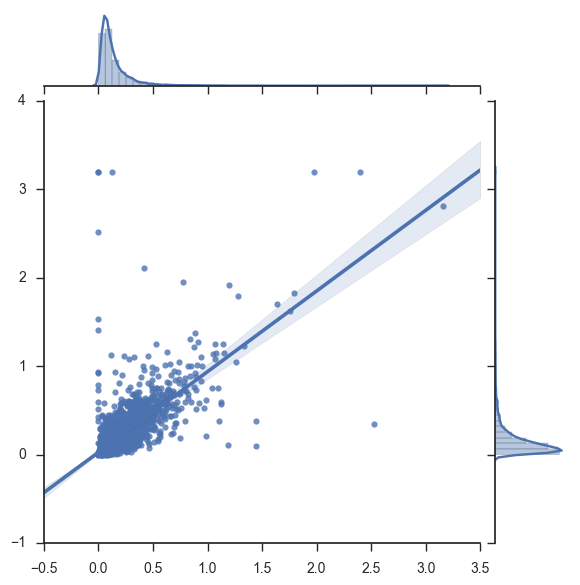

In [14]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="ticks", color_codes=True)

# we set a maximum value for dN/dS to avoid strong influence of outliers (e.g. the 5 genes that have dN/dS = 99.0)
# the maximum dN/dS in the data set of Sperschneider et al. is 3.1625
max_value = 3.2

dNdS_Sper = []
dNdS_Fver = []
gene2dNdS = {}
for line in open('Foxy_DiversifyingSelection__SOM_SperschneiderGBE.csv').readlines()[1:]:
    data = line.split(',')
    gene = data[0]
    
    if gene2dN.has_key(gene) and gene2dS.has_key(gene):
        dNdS_Sper.append(min(max_value, float(data[1])))
        dNdS = 0
        if gene2dS[gene] > 0:
            dNdS = min(gene2dN[gene]/gene2dS[gene], max_value)
        else:
            dNdS = max_value
        
        gene2dNdS[gene] = dNdS 
        dNdS_Fver.append(dNdS)
        
        
R, Pvalue = stats.spearmanr(np.array(dNdS_Sper), np.array(dNdS_Fver))
print 'Spearman correlation:', R
print 'P-value:', Pvalue


g = sns.JointGrid(x=np.array(dNdS_Sper), y=np.array(dNdS_Fver))
g = g.plot(sns.regplot, sns.distplot)
plt.show()

We expect that outliers will be mostly genes that have a homolog in _F. verticillioides_, but a more similar homolog in an other fusarium species that is not included in our analyses, but is in Sperschneider et al.'s. This is consistent with the fact that we see more point above the diagonal than below.  


### Do genes on the fast-core have higher dN, dS or dN/dS values than genes on the core?
We compare the number of synonymous (dS) with the number of non-synonymous (dN) substitutions in genes that lie on the core  with genes that lie on the fast-core chromosomes. Moreover, we compare the dN and dS for genes that are differentially regulated during infection.


#### Get sets of core and of fast-core genes

In [ ]:
core_genes = set([])
for chr in cat2chrs['core']:
    print ('\n\n***\t', chr, '\t***')
    # get number of genes on this chromosome
    chr_genes = set([])
    for scaffold in chr2scaffolds[chr]:
        chr_genes = chr_genes.union(scaffold2genes['Supercontig_2.'+str(scaffold)])
    core_genes = core_genes.union(chr_genes)
    
fc_genes = set([])
for chr in cat2chrs['fast-core']:
    print ('\n\n***\t', chr, '\t***')
    # get number of genes on this chromosome
    chr_genes = set([])
    for scaffold in chr2scaffolds[chr]:
        chr_genes = chr_genes.union(scaffold2genes['Supercontig_2.'+str(scaffold)])
    fc_genes = fc_genes.union(chr_genes)

 


DEG
Core: 10166 10166 SUB: 895 895
Fast-Core: 1912 1912 SUB: 389 389
dN


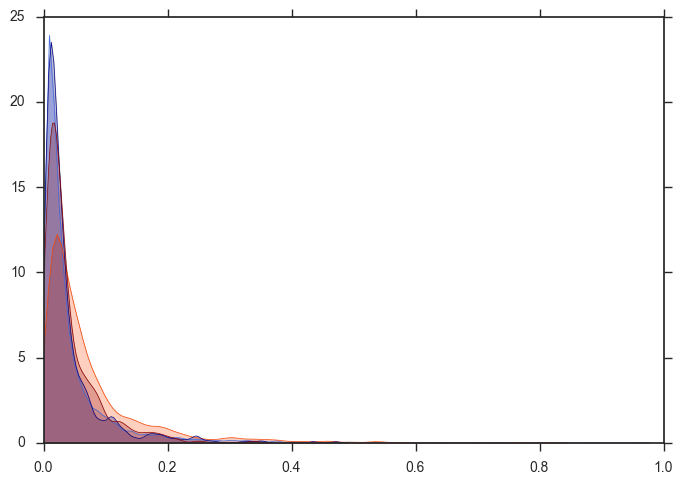

dS


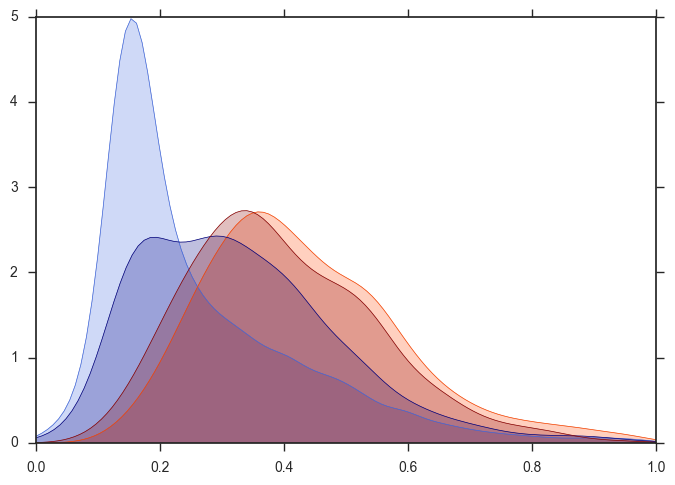

Core versus Fast-core


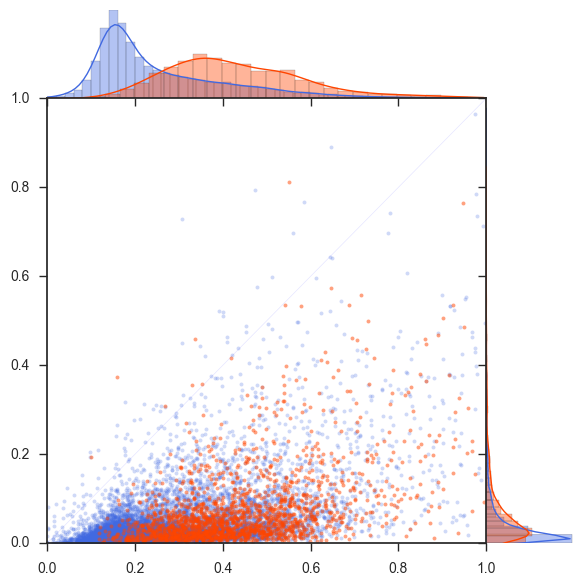

DEG: Core versus Fast-core


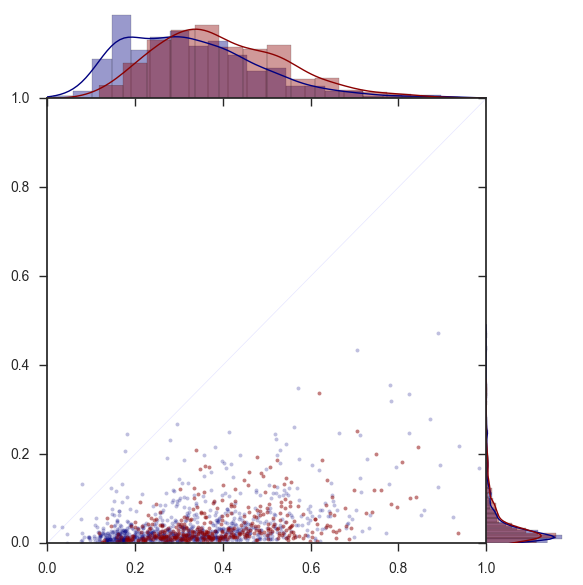

DEG versus not DEG


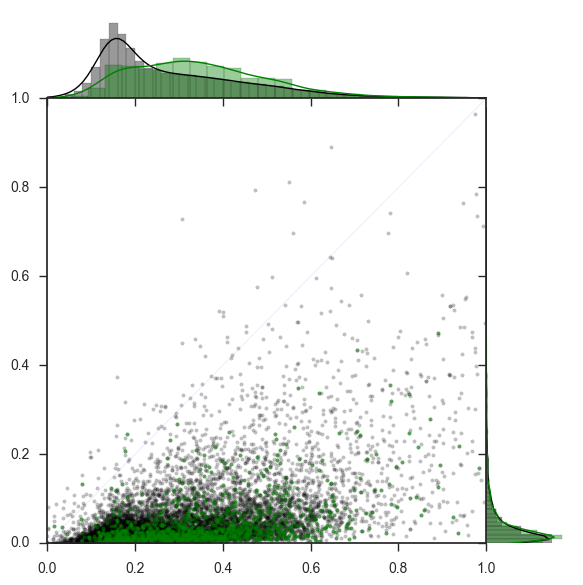

Core: DEG versus not DEG


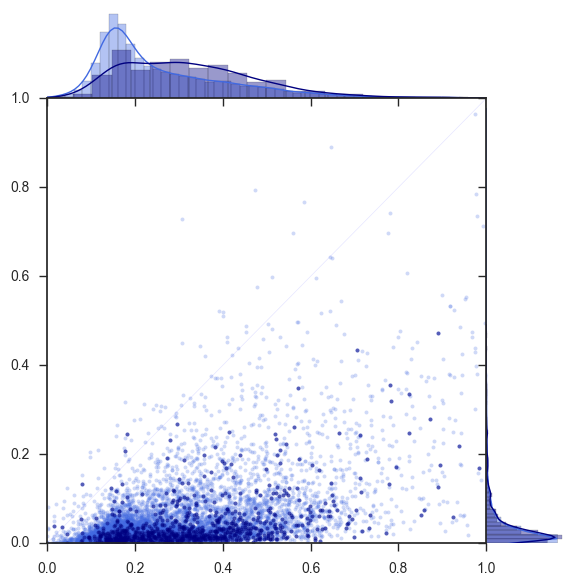

Fast-core: DEG versus not DEG


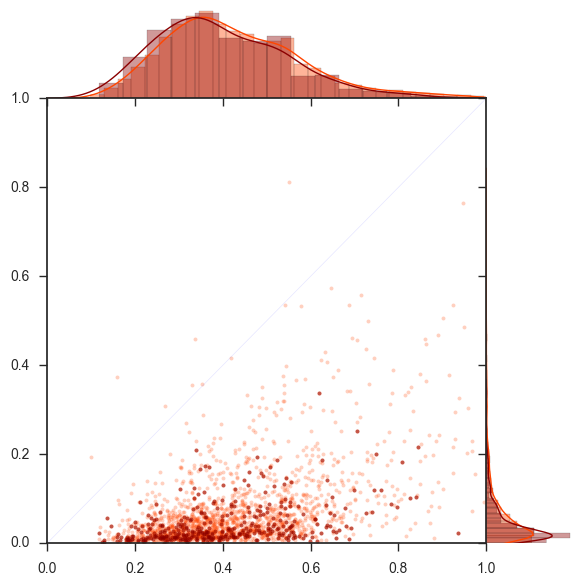

UP
Core: 10166 10166 SUB: 668 668
Fast-Core: 1912 1912 SUB: 289 289
dN


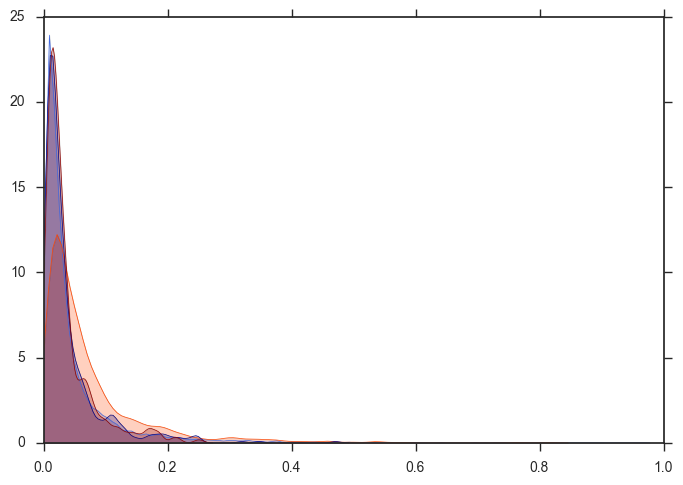

dS


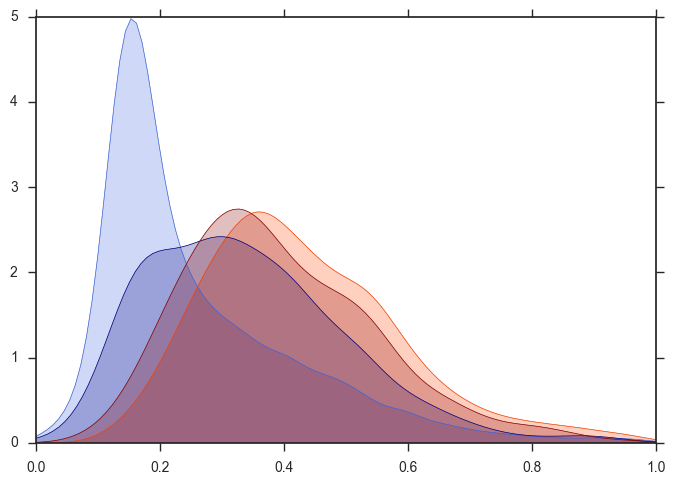

Core versus Fast-core


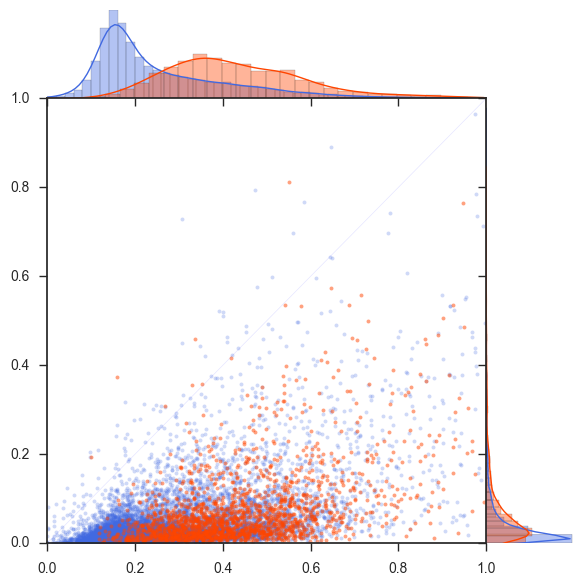

UP: Core versus Fast-core


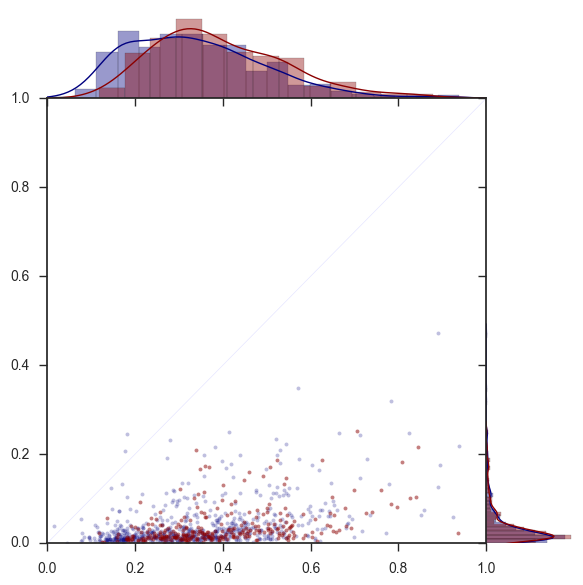

UP versus not UP


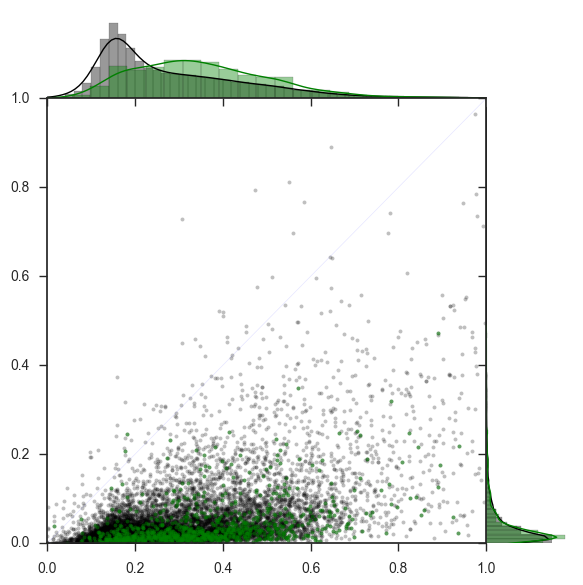

Core: UP versus not UP


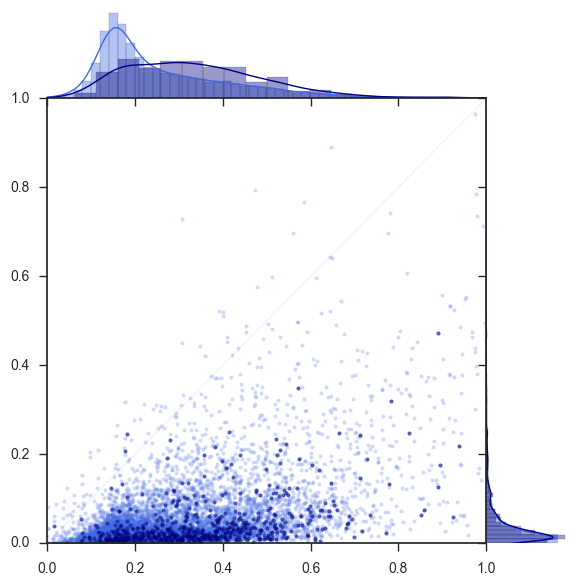

Fast-core: UP versus not UP


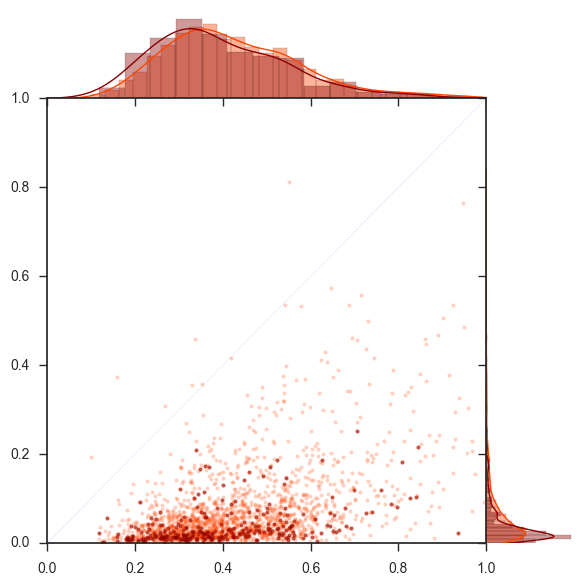

H3K27Me3
Core: 10166 10166 SUB: 2281 2281
Fast-Core: 1912 1912 SUB: 1812 1812
dN


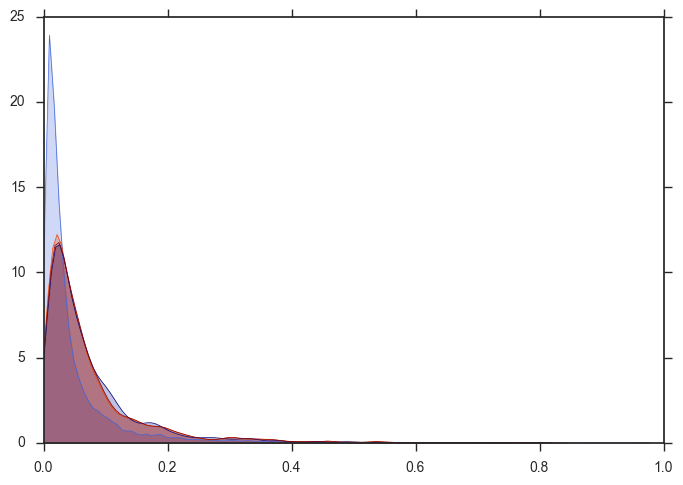

dS


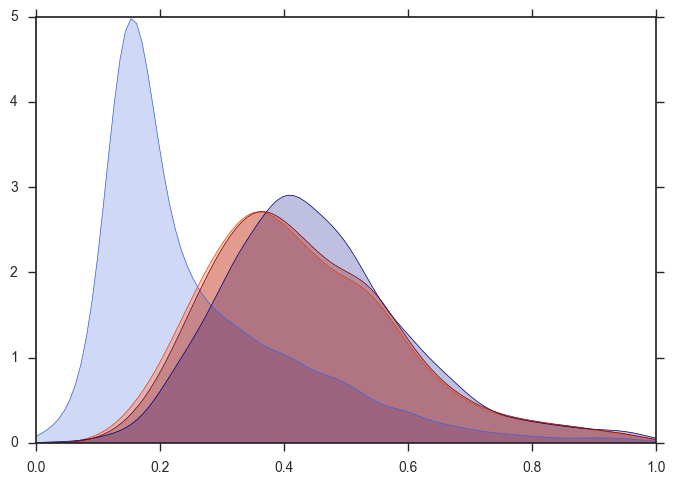

Core versus Fast-core


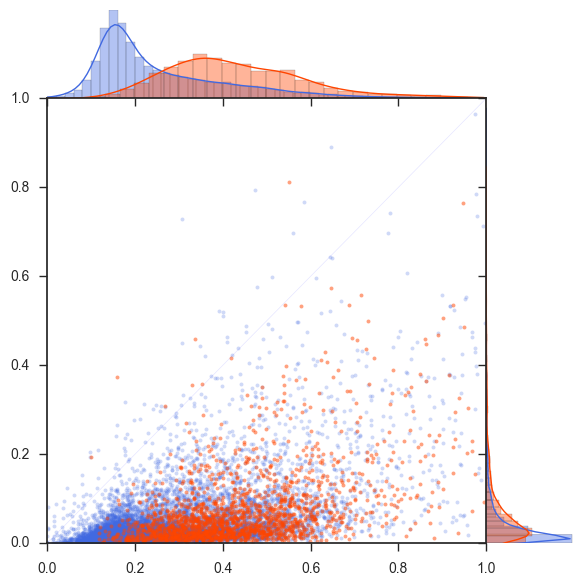

H3K27Me3: Core versus Fast-core


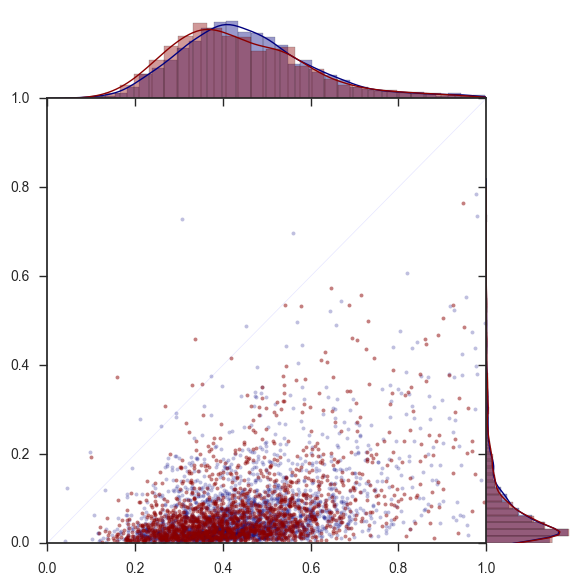

H3K27Me3 versus not H3K27Me3


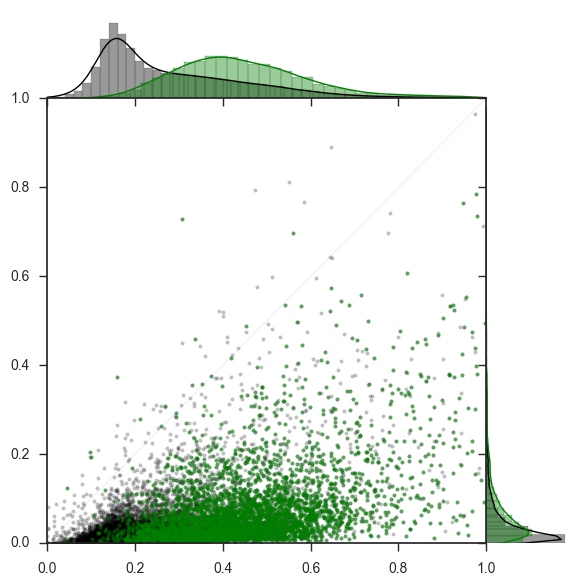

Core: H3K27Me3 versus not H3K27Me3


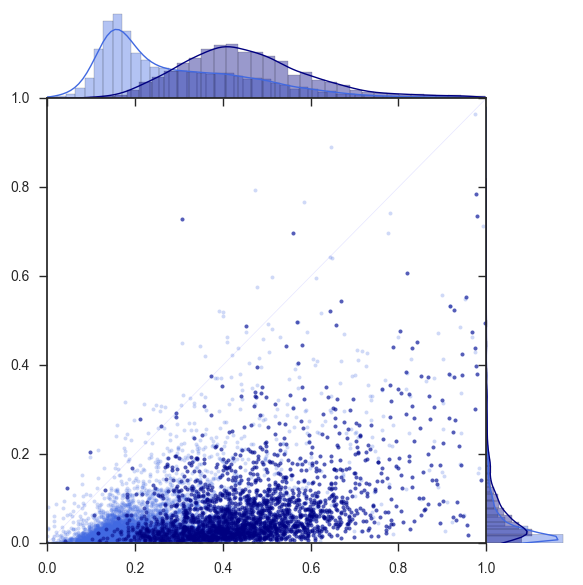

Fast-core: H3K27Me3 versus not H3K27Me3


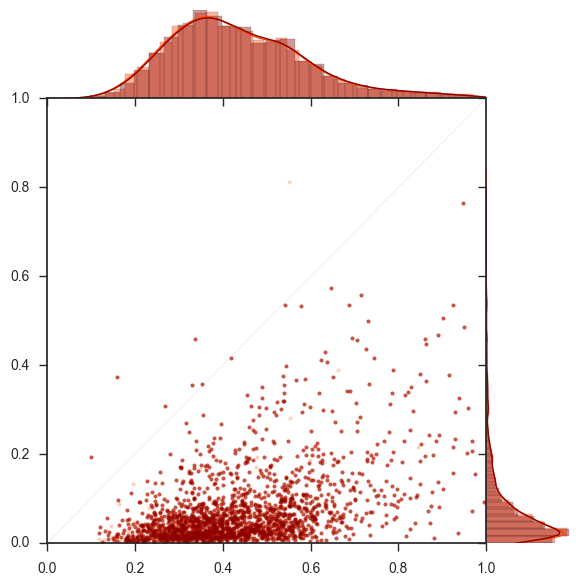

In [16]:

# Make a scatterplot of synonymous versus non synonymous substitions, 
# differentiating between genes that lie on the core and genes that 
# lie on the fast-core, or genes that are upregulated in planta to genes that are not.


# get x and y values per subcategory: genes that are in the subselection
# and genes that are not (incl = false) or genes that are in the subselection + genes that are not)
# return 4 lists that can be used for plotting
def get_XYvalues_per_cat(geneset, subselection, gene2x, gene2y, incl = True):
    x_values_cat1 = []
    x_values_cat2 = []
    y_values_cat1 = []
    y_values_cat2 = []
    
    for gene in geneset:
        if gene2x.has_key(gene) and gene2y.has_key(gene):
            if gene in subselection:
                x_values_cat1.append(gene2x[gene])
                y_values_cat1.append(gene2y[gene])
                if incl:
                    x_values_cat2.append(gene2x[gene])
                    y_values_cat2.append(gene2y[gene])
            else:
                x_values_cat2.append(gene2x[gene])
                y_values_cat2.append(gene2y[gene])
                
    return x_values_cat1, y_values_cat1, x_values_cat2, y_values_cat2


core_color     = 'royalblue'
core_sub_color = 'navy'
fc_color       = 'orangered'
fc_sub_color   = 'darkred'
    
subcats  = [DEG_genes, UP_genes, genes_in_H3K27Me3, genes_in_H]
subnames = ['DEG', 'UP', 'H3K27Me3'] 
for i, subcat in enumerate(subcats):
    print subnames[i]
    core_sub_dS, core_sub_dN, core_dS, core_dN = get_XYvalues_per_cat(core_genes, subcat, gene2dS, gene2dN)
    fc_sub_dS, fc_sub_dN, fc_dS, fc_dN         = get_XYvalues_per_cat(fc_genes, subcat, gene2dS, gene2dN)
    
    print 'Core:', len(core_dS), len(core_dN), 'SUB:', len(core_sub_dS), len(core_sub_dN)
    print 'Fast-Core:', len(fc_dS), len(fc_dN), 'SUB:', len(fc_sub_dS), len(fc_sub_dN)
    # make histogram of different categories:
    print 'dN'
    plt.Figure()
    ax = sns.distplot(core_dN, color = core_color, hist = False, kde_kws = {'linewidth': 0.5, 'shade': True})
    sns.distplot(fc_dN, color = fc_color, ax = ax, hist = False, kde_kws = {'linewidth': 0.5, 'shade': True})
    sns.distplot(core_sub_dN, color = core_sub_color, ax = ax, hist = False, kde_kws = {'linewidth': 0.5, 'shade': True})
    sns.distplot(fc_sub_dN, color = fc_sub_color, ax = ax, hist = False, kde_kws = {'linewidth': 0.5, 'shade': True})
    ax.set_xlim(0, 1)
    plt.savefig('KDE_'+subnames[i]+'_dN.svg', dpi = 700)
    plt.show()
    plt.close()
        
    print 'dS'
    plt.Figure()
    ax = sns.distplot(core_dS, color = core_color, hist = False, kde_kws = {'linewidth': 0.5, 'shade': True})
    sns.distplot(fc_dS, color = fc_color, ax = ax, hist = False, kde_kws = {'linewidth': 0.5, 'shade': True})
    sns.distplot(core_sub_dS, color = core_sub_color, ax = ax, hist = False, kde_kws = {'linewidth': 0.5, 'shade': True})
    sns.distplot(fc_sub_dS, color = fc_sub_color, ax = ax, hist = False, kde_kws = {'linewidth': 0.5, 'shade': True})
    ax.set_xlim(0, 1)
    plt.savefig('KDE_'+subnames[i]+'_dS.svg', dpi = 700)
    plt.show()
    plt.close()
        
    


We see especially in the KDE plots that core genes that are in H3K27Me3-ated regions are similar to fast-core genes wrt dN and dS values. Let's test whether this is statistically significant

In [31]:
import numpy as np

print 'Slow-core versus fast-core:'

def compare_values(catA, catB, gene2value):
    valuesA  = []
    valuesB = []
    
    for gene in catA:
        if gene2value.has_key(gene): valuesA.append(gene2value[gene])
    for gene in catB:
        if gene2value.has_key(gene): valuesB.append(gene2value[gene])
    
    #print len(valuesA), len(set(valuesA))
    #print len(valuesB), len(set(valuesB))
                
    # T-test independent samples (test for equal means)
    print "Welch's T-test:"
    print "mean cat A:", np.mean(valuesA)
    print "mean cat B:", np.mean(valuesB)
    print 'P-value:', stats.ttest_ind(valuesA, valuesB, equal_var = False)[1], '\n'
    
    # Rank data to ensure normal distributions
    values = valuesA + valuesB
    values_rank = stats.rankdata(values, method='average') # generates a list with ranks (corresponding to input list) 
    valuesA_ranked = values_rank[:len(valuesA)]
    valuesB_ranked = values_rank[len(valuesA):]
    
    if len(valuesA) != len(valuesA_ranked): print 'len(valuesA) != len(valuesA_ranked)'
    if len(valuesB) != len(valuesB_ranked): print 'len(valuesB) != len(valuesB_ranked)'
    print "Welch's T-test on ranked data:"
    print "mean cat A:", np.mean(valuesA_ranked)
    print "mean cat B:", np.mean(valuesB_ranked)
    print 'P-value:', stats.ttest_ind(valuesA_ranked, valuesB_ranked, equal_var = False)[1]
    
    
print 'Compare dN, dS and dN/dS between slow-core and fast-core genes:'
print '*** dS' 
compare_values(fc_genes, core_genes, gene2dS)
print '\n\n*** dN' 
compare_values(fc_genes, core_genes, gene2dN)
print '\n\n*** dNdS' 
compare_values(fc_genes, core_genes, gene2dNdS)

print '\n\n\t***************\n\n'
print 'Compare dN, dS and dN/dS between DEGs and non DEGs:'
print '*** dS' 
compare_values(DEG_genes, set(gene2dS.keys()), gene2dS)
print '\n\n*** dN' 
compare_values(DEG_genes, set(gene2dN.keys()), gene2dN)
print '\n\n*** dNdS' 
compare_values(DEG_genes, set(gene2dNdS.keys()), gene2dNdS)


print '\n\n\t***************\n\n'
print 'Compare dN, dS and dN/dS between genes located in H3K27Me3-ated region and those that are not:'
print '*** dS' 
compare_values(genes_in_H3K27Me3, set(gene2dS.keys()), gene2dS)
print '\n\n*** dN' 
compare_values(genes_in_H3K27Me3, set(gene2dN.keys()), gene2dN)
print '\n\n*** dNdS' 
compare_values(genes_in_H3K27Me3, set(gene2dNdS.keys()), gene2dNdS)





Slow-core versus fast-core:
Compare dN, dS and dN/dS between slow-core and fast-core genes:
*** dS
Welch's T-test:
mean cat A: 0.432091945607
mean cat B: 0.262851711588
P-value: 7.91163946535e-307 

Welch's T-test on ranked data:
mean cat A: 9102.32871339
mean cat B: 5463.44958686
P-value: 0.0


*** dN
Welch's T-test:
mean cat A: 0.0717698221757
mean cat B: 0.0443305134763
P-value: 2.71923846409e-39 

Welch's T-test on ranked data:
mean cat A: 7775.32217573
mean cat B: 5713.0301987
P-value: 3.35701115976e-142


*** dNdS
Welch's T-test:
mean cat A: 0.153266842434
mean cat B: 0.156479855054
P-value: 0.610505032857 

Welch's T-test on ranked data:
mean cat A: 2723.63461538
mean cat B: 2552.20719375
P-value: 0.00144027996702


	***************


Compare dN, dS and dN/dS between DEGs and non DEGs:
*** dS
Welch's T-test:
mean cat A: 0.354647640449
mean cat B: 0.293329309227
P-value: 1.99652674145e-37 

Welch's T-test on ranked data:
mean cat A: 8434.27752809
mean cat B: 6661.89837036
P-value

In [ ]:
#### Upregulated genes
print "Are genes that are upregulated during infection under positive selection?"
for test in tests:   
    pos_sel_genes = set(test2genes[test][0])
    tested_genes  = set(test2genes[test][1])
    
    all_genes = tested_genes

    M = len(all_genes)
    n = len(pos_sel_genes)
    N = len(UP_genes.intersection(tested_genes))
    x = len(UP_genes.intersection(pos_sel_genes))

    print test+': scipy.stats.hypergeom.sf('+str(M)+','+str(n)+','+str(N)+','+str(x)+')'
    print 'P-value:', stats.hypergeom.sf(x, M, n, N)
    print 
    print 'Contingency:'
    print x, N-x, N
    print n-x,  (M-n) - (N-x), M-N
    print n, M-n, M
    print '\n\n'

#### Downregulated genes
print "Are genes that are downregulated during infection under positive selection?"
for test in tests:   
    pos_sel_genes = set(test2genes[test][0])
    tested_genes  = set(test2genes[test][1])
    
    all_genes = tested_genes

    M = len(all_genes)
    n = len(pos_sel_genes)
    N = len(DOWN_genes.intersection(tested_genes))
    x = len(DOWN_genes.intersection(pos_sel_genes))

    print test+': scipy.stats.hypergeom.sf('+str(M)+','+str(n)+','+str(N)+','+str(x)+')'
    print 'P-value:', stats.hypergeom.sf(x, M, n, N)
    print 
    print 'Contingency:'
    print x, N-x, N
    print n-x,  (M-n) - (N-x), M-N
    print n, M-n, M
    print '\n\n'


#### Differentially regulated genes
print "Are genes that are differentially regulated during infection under positive selection?"
for test in tests:   
    pos_sel_genes = set(test2genes[test][0])
    tested_genes  = set(test2genes[test][1])
    
    all_genes = tested_genes

    M = len(all_genes)
    n = len(pos_sel_genes)
    N = len(DEG_genes.intersection(tested_genes))
    x = len(DEG_genes.intersection(pos_sel_genes))

    print test+': scipy.stats.hypergeom.sf('+str(M)+','+str(n)+','+str(N)+','+str(x)+')'
    print 'P-value:', stats.hypergeom.sf(x, M, n, N)
    print 
    print 'Contingency:'
    print x, N-x, N
    print n-x,  (M-n) - (N-x), M-N
    print n, M-n, M
    print '\n\n'



